In [100]:
import torch
import numpy as np
from matplotlib import pyplot as plt


Toy datasets

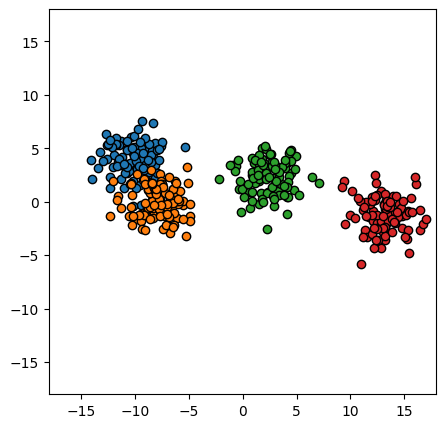

In [172]:
means = [[-10,4],
         [-7.5, 0],
         [2.5,2.5],
         [13, -1]]

cov = [[2.7,0],
       [0,2.7]]

# means = [[-10,4],
#          [-7.5, -12],
#          [2.5,12],
#          [13, -1]]

# cov = [[2.7,0],
#        [0,2.7]]



classes = list(range(4))
data = {}
fig, ax = plt.subplots(1,1,figsize=(5,5))
X = []
Y = []
for c in classes:
    num_data_points = 100
    x = np.random.multivariate_normal(mean=means[c], cov=cov,size=num_data_points)
    y = np.ones(num_data_points)*c
    data[c] = x
    v = 18
    ax.set_xlim((-v,v))
    ax.set_ylim((-v,v))
    ax.scatter(x[:,0], x[:,1],edgecolors='black')
    
    X.append(x)
    Y.append(y)
X = np.concatenate(X)
Y = np.concatenate(Y)

In [173]:
from torch import nn
from torch import optim
from torch.nn import functional as F
torch.manual_seed(99_999)
m,n = X.shape
h = 20 # num hidden units
k = 4 # num. classes

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU()
        )
        self.clf = nn.Linear(h, k, bias = False)
        
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
    
model = Model()
opt = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9, weight_decay=5e-4)

for it in range(5000):
    y = model(X_train)
    l = F.cross_entropy(y, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
    if not it % 1000:
        print(f'Loss:{l.item():.3f}')

Loss:1.504
Loss:0.141
Loss:0.120
Loss:0.112
Loss:0.109


In [174]:
preds = np.argmax(model(torch.from_numpy(X).float()).detach().numpy(), axis = -1)
np.equal(preds, Y).mean()


0.9575

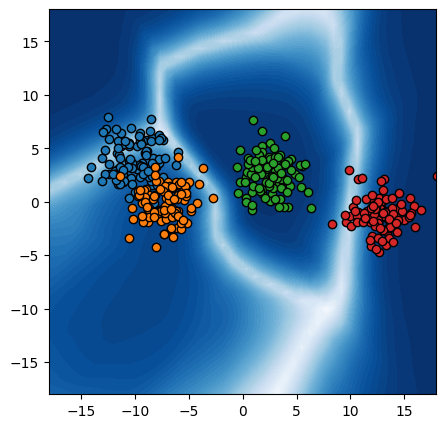

In [175]:

cells = 50
x = np.linspace(-v,v,cells)
y = np.linspace(-v,v,cells)

xx, yy = np.meshgrid(x,y)
grid_data = torch.from_numpy(np.array(list(zip(xx.reshape(-1), yy.reshape(-1))))).float()

with torch.no_grad():
    y_pred = model(grid_data)
    max_prob = torch.max(F.softmax(y_pred, dim=-1), dim = -1,)
max_prob = max_prob[0].detach().numpy()
fig, ax = plt.subplots(1,1, figsize = (5,5))

# plot softmax probability
levels = 50
ax.contourf(xx, yy, max_prob.reshape(cells, cells), cmap = 'Blues', levels = levels)

for c in classes:
    num_data_points = 100
    x = np.random.multivariate_normal(mean=means[c], cov=cov,size=num_data_points)
    y = np.ones(num_data_points)*c
    data[c] = x
    v = 18
    ax.set_xlim((-v,v))
    ax.set_ylim((-v,v))
    ax.scatter(x[:,0], x[:,1],edgecolors='black')





In [176]:
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal
from math import sqrt

W = list(model.parameters())[-1]
shape_W = W.shape

# Use Backpack to get the Kronecker-factored last-layer covariance
extend(model.clf)
loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))
loss = loss_func(model(X_train), y_train)
with backpack(extensions.KFAC()):
    loss.backward()
    
# the Kronecker-factored Hessian of the negative log-posterior
A,B = W.kfac

# the weight decays used for training is the Gaussian prior's precision
prec0 = 5e-4

# The posterior covariance's Kronecker factors
U = torch.inverse(A + sqrt(prec0) * torch.eye(shape_W[0]))
V = torch.inverse(B + sqrt(prec0) * torch.eye(shape_W[1]))

@torch.no_grad()
def predict(x):
    phi = model.feature_extr(x)   
    
    # MAP prediction
    m = phi @ W.T
    
    # v is the induced covariance
    # See Appendix B.1 of https://arxiv.org/abs/2992.10118 for the details of the derivation
    v = torch.diag(phi @ V @ phi.T).reshape(-1,1,1) * U
    
    # The induced distribution over the output(pre-softmax)
    output_dist = MultivariateNormal(m, v)
    
    # MC-integral
    n_sample = 1000
    py = 0
    for _ in range(n_sample):
        out_s = output_dist.rsample()
        py += torch.softmax(out_s, 1)
    
    py /= n_sample
    return py.numpy()

py = predict(grid_data)

        


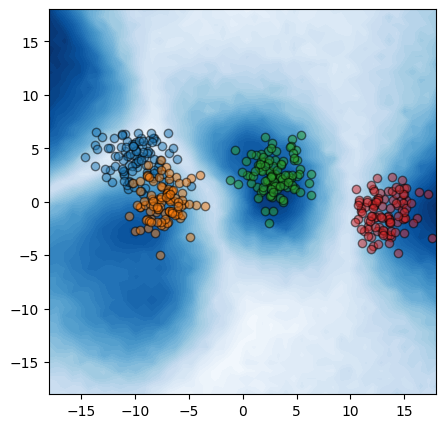

In [180]:
max_prob = np.max(py, axis = -1,)
fig, ax = plt.subplots(1,1, figsize = (5,5))

# plot softmax probability
levels = 50
ax.contourf(xx, yy, max_prob.reshape(cells, cells), cmap = 'Blues', levels = levels)

for c in classes:
    num_data_points = 100
    x = np.random.multivariate_normal(mean=means[c], cov=cov,size=num_data_points)
    y = np.ones(num_data_points)*c
    data[c] = x
    v = 18
    ax.set_xlim((-v,v))
    ax.set_ylim((-v,v))
    ax.scatter(x[:,0], x[:,1],edgecolors='black', alpha = 0.5)

    



In [178]:
preds = np.argmax(predict(torch.from_numpy(X).float()), axis = -1)
np.equal(preds, Y).mean()


0.9575

In [184]:
py.max()

0.95416737